---
author: Darren Biskup
date: September 21 2025
title: Homework 3 - Kalman Filter

jupyter: python3
embed-resources: true
---

**1. (20pts) Consider a drone taking off vertically by producing a constant thrust force with its
propellers. The drone has an infrared sensor that shoots downwards and measures the
altitude. The drone mass ($m$) and sampling rate ($Δt$) are parameters known to the
system.**

**Assume that the drone can control the thrust directly (this is a simplifying assumption,
usually the model is more complex and includes the motor dynamics and the propeller
model), but the signal is noisy. The input noise is Gaussian with standard deviation $σ_T$.
The altitude measurement coming from the infrared sensor is also a Gaussian process
with standard deviation $σ_h$.**

**Write the discrete-time model in canonical form that is to be used to implement the
Kalman filter that estimates the drone altitude. Specify the $A$, $B$, $C$ matrices of the model
and covariance matrices of the input ($Σ_u$) and measurement ($Σ_z$). What is the
dimension of state covariance? Show all derivations starting from first principles of laws
of motion.**

First start by writing the equations of motion of the 1-DOF system. From Newton's laws:

$$
m\ddot{h} = u - mg + \text{noise} \\
$$

we are also told that our measurement of the altitude is known to contain some noise $\epsilon_h$

$$
z = h + \epsilon_h
$$

The Kalman Filter algorithm expects state transition dynamics to be *Linear Gaussian*, and right now due to the gravity term the dynamics equations can't direclty be transcribed to this form. Therefore, if we instead define our state variable as

$$
x = \begin{bmatrix} h & \dot{h} & 1\end{bmatrix}^\top
$$

then the dynamics can then be expressed in continuous time as follows:

$$
\dot{x} = Ax + Bu + \epsilon_t
$$
expanded:
$$
\dot{x} = \begin{bmatrix} \dot{h} \\ \ddot{h} \\ 1\end{bmatrix} =
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & -g \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix} h \\ \dot{h} \\ 1\end{bmatrix}
+
\begin{bmatrix} 0 \\ 1/m \\ 0\end{bmatrix}
u
+ \epsilon_t
$$

$$
\epsilon_t \sim \mathcal{N}(0, B\Sigma_u B^\top) ,\quad \Sigma_u = 
\begin{bmatrix}\sigma_{t}^2\end{bmatrix}
$$

and the observation/measurement is updated from the state as:

$$
z = Cx + \epsilon_h = \begin{bmatrix} 1 & 0 & 0\end{bmatrix} \begin{bmatrix} h \\ \dot{h} \\ 1\end{bmatrix} + \epsilon_h
$$
$$
\epsilon_h \sim \mathcal{N}(0, \Sigma_z), \quad \Sigma_z = \begin{bmatrix} \sigma_h^2 \end{bmatrix}
$$

To convert to a discrete time model suitable for usage in an online recursive Kalman Filter implementation, we can apply a first order Euler discretization as follows:

$$
\begin{aligned}
A_d &= I + \Delta t \cdot A \\
B_d &= \Delta t \cdot B
\end{aligned}
$$

then:

$$
\boxed{x_{t+1} = A_d x_{t - 1} + B_d u_t + \epsilon_t}
$$

$$
\boxed{
A_d = \begin{bmatrix}
1 & \Delta t & 0 \\
0 & 1 & -g \Delta t \\
0 & 0 & 1
\end{bmatrix}, \quad
B_d = \begin{bmatrix}
0 \\
\frac{\Delta t}{m} \\
0
\end{bmatrix}
}
$$

We are told that the input noise is Gaussian with standard deviation $σ_T$, therefore the vectorized noise term (when separated out of input $u$) in discrete time is:

$$
\boxed{
\epsilon_t \sim \mathcal{N}(0, B_d \Sigma_u B_d^\top) ,\quad  B_d \Sigma_u B_d^\top = \sigma_T^2 B_d B_d^\top
=
\begin{bmatrix}
0 & 0 & 0 \\
0 & \Delta t^2\frac{\sigma_{T}^2}{m^2} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
}
$$


The measurement model matrices remain unchanged when discretized:

$$
\boxed{z = Cx + \epsilon_h = \begin{bmatrix} 1 & 0 & 0\end{bmatrix} \begin{bmatrix} h \\ \dot{h} \\ 1\end{bmatrix} + \epsilon_h
}
$$
$$
\boxed{
\epsilon_h \sim \mathcal{N}(0, \Sigma_z), \quad \Sigma_z = \begin{bmatrix} \sigma_h \end{bmatrix}
}
$$


(Abuse of notation: reused the symbols $\epsilon_t$, $\Sigma_u$, $\epsilon_h$, and $\Sigma_z$ to represent both the continuous-time and discrete-time noise terms and their covariances, which can change under discretization.)


The state covariance matrix will have the same dimensions as $B_d\Sigma_u B_d^\top$ which is $\mathbb{R}^{3 \times 3}$ due to the augmentation of the state matrix, however the nonzero upper left portion representing the covariance matrix of the "relevant" states is $\mathbb{R}^{2 \times 2}$

**2. (30pts) Using the cartesian robot code from class as the reference, modify the program 
to simulate the drone liftoff and use the Kalman filter to estimate the altitude. Assume the 
following parameters:**

- Drone mass is 0.25kg
- Sampling rate is 200Hz
- Propellers are producing a constant thrust of 2.7N with variance of 0.25N².
- Measurement sample uncertainty is Gaussian but the variance value changes for each sample with uniform distribution between 0.01m² and 0.5m². Assume that the sensor correctly reports the variance.
- Only the first 5 seconds of simulation are of interest.

**Simulate the following cases:**

- Altitude is obtained by “stealing” the ground truth from the simulator.
- Altitude is taken at “face value” from the sensor without the Kalman filter.
- Altitude is estimated by the Kalman filter and the models are matched.
- Altitude is estimated by the Kalman filter, but the estimator has the mass parameter incorrectly set to 10% higher than the actual mass.

**Plot the altitude for all four cases above (four plots on one figure, use different colors for 
each signal, do not use large markers that obscure the readability of the plot). Also plot 
the difference (error) between the ground truth and the estimate for the three cases 
above (three plots on one figure). Your plots must either include the legend or you must 
list which signal is which in your submission. Comment on the effect of the model 
mismatch. How does it impact the filter output?**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class QuadrotorKF:
    def __init__(self):
        self.m = 0.25  # mass of the quadrotor (kg)
        self.fs = 200  # sampling frequency (Hz)
        self.dt = 1 / self.fs  # sampling period (s)

        self.state = np.array([0, 0, 1])
        
        self.R_t = np.zeros((3, 3))
        self.R_t[1, 1] = self.dt**2 * 0.25 / self.m**2 

        # Initial state covariance
        self.state_cov = np.identity(3)
        self.state_cov[2, 2] = 0  # never uncertainty in augmented state

        self.predicted_state = self.state.copy()
        self.predicted_state_cov = np.zeros((3, 3))
        self.time = 0  # initial timestamp

    def set_state(self, timestamp, height=0, velocity=0):
        self.time = timestamp
        self.state[0] = height
        self.state[1] = velocity
        self.predicted_state = self.state.copy()

    def A_matrix(self, dt):
        A = np.array([
            [1, dt, 0],
            [0, 1, -9.81 * dt],
            [0, 0, 1]
        ])
        return A

    def B_matrix(self, dt):
        return np.array([0, dt / self.m, 0])

    def C_matrix(self):
        return np.array([[1, 0, 0]])

    def _predict(self, timestamp, prev_state, prev_state_cov, u, z, Q):
        delta_t = timestamp - self.time if timestamp > self.time else self.dt
        self.time = timestamp

        A = self.A_matrix(delta_t)
        B = self.B_matrix(delta_t)
        C = self.C_matrix()

        mu_bar = A @ prev_state + B * u
        Sigma_bar = A @ prev_state_cov @ A.T + self.R_t
        
        mu_bar[2] = 1  # maintain augmented state as 1
        Sigma_bar[2, 2] = 0  # maintain augmented state covariance as 0

        S = float(C @ Sigma_bar @ C.T + Q)
        K_t = (Sigma_bar @ C.T) / S if S > 1e-10 else np.zeros((3, 1))
        innovation = z - float(C @ mu_bar)
        self.predicted_state = mu_bar + K_t.flatten() * innovation
        
        self.predicted_state_cov = (np.identity(3) - K_t @ C) @ Sigma_bar
        
        self.predicted_state[2] = 1  # maintain augmented state
        self.predicted_state_cov[2, 2] = 0  # maintain augmented state covariance

    def simulate_system(self, u):
        A = self.A_matrix(self.dt)
        B = self.B_matrix(self.dt)

        self.state = A @ self.state + B * u
        self.state[2] = 1  # maintain augmented state

    def get_state(self):
        return self.state, self.state_cov
    
    def get_estimate(self):
        return self.predicted_state, self.predicted_state_cov

In [2]:
quadrotor_model = QuadrotorKF()
quadrotor_model.set_state(0)

estimator = QuadrotorKF()
estimator.set_state(0)

estimator_stealing = QuadrotorKF()
estimator_stealing.set_state(0)

estimator_unfiltered = QuadrotorKF()
estimator_unfiltered.set_state(0)

estimator_wrong_mass = QuadrotorKF()
estimator_wrong_mass.set_state(0)
estimator_wrong_mass.m = 0.25 * 1.1  # 10% higher mass

t = quadrotor_model.dt
all_t = [i * quadrotor_model.dt for i in range(1, 1001)] # simulate for 5 seconds

# input thrust with noise
u = 2.7  # nominal thrust to hover (N)
all_u_delivered = np.random.normal(loc=u, scale=np.sqrt(0.25), size=len(all_t))

height_ground_truth = []
height_estimate_stolen = []
height_estimate_unfiltered = []
height_estimate_kf = []
height_estimate_kf_wrong_mass = []

def generate_measurement(state):
    sensor_variance = np.random.uniform(0.01, 0.5)
    z = np.random.normal(loc=state[0], scale=np.sqrt(sensor_variance))
    return z, sensor_variance

for i in range(len(all_t)):
    # move the system under simulation using noisy input
    quadrotor_model.simulate_system(all_u_delivered[i])
    height_ground_truth.append(quadrotor_model.state[0])
    
    # Case 1: "stealing" ground truth
    estimator_stealing._predict(all_t[i], estimator_stealing.state, estimator_stealing.state_cov, u, quadrotor_model.state[0], 0)
    estimator_stealing.state = estimator_stealing.predicted_state
    estimator_stealing.state_cov = estimator_stealing.predicted_state_cov
    height_estimate_stolen.append(estimator_stealing.state[0])
    
    # Case 2: Raw sensor measurement without filtering
    z, Q = generate_measurement(quadrotor_model.state)
    estimator_unfiltered.simulate_system(all_u_delivered[i])
    height_estimate_unfiltered.append(z)
    
    # Case 3: Standard Kalman filter
    z, Q = generate_measurement(quadrotor_model.state)
    estimator._predict(all_t[i], estimator.state, estimator.state_cov, u, z, Q)
    estimator.state = estimator.predicted_state
    estimator.state_cov = estimator.predicted_state_cov
    height_estimate_kf.append(estimator.state[0])
    
    # Case 4: Kalman filter with wrong mass
    estimator_wrong_mass._predict(all_t[i], estimator_wrong_mass.state, estimator_wrong_mass.state_cov, u, z, Q)
    estimator_wrong_mass.state = estimator_wrong_mass.predicted_state
    estimator_wrong_mass.state_cov = estimator_wrong_mass.predicted_state_cov
    height_estimate_kf_wrong_mass.append(estimator_wrong_mass.state[0])


/tmp/ipykernel_59677/2384142179.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(C @ Sigma_bar @ C.T + Q)
/tmp/ipykernel_59677/2384142179.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  innovation = z - float(C @ mu_bar)


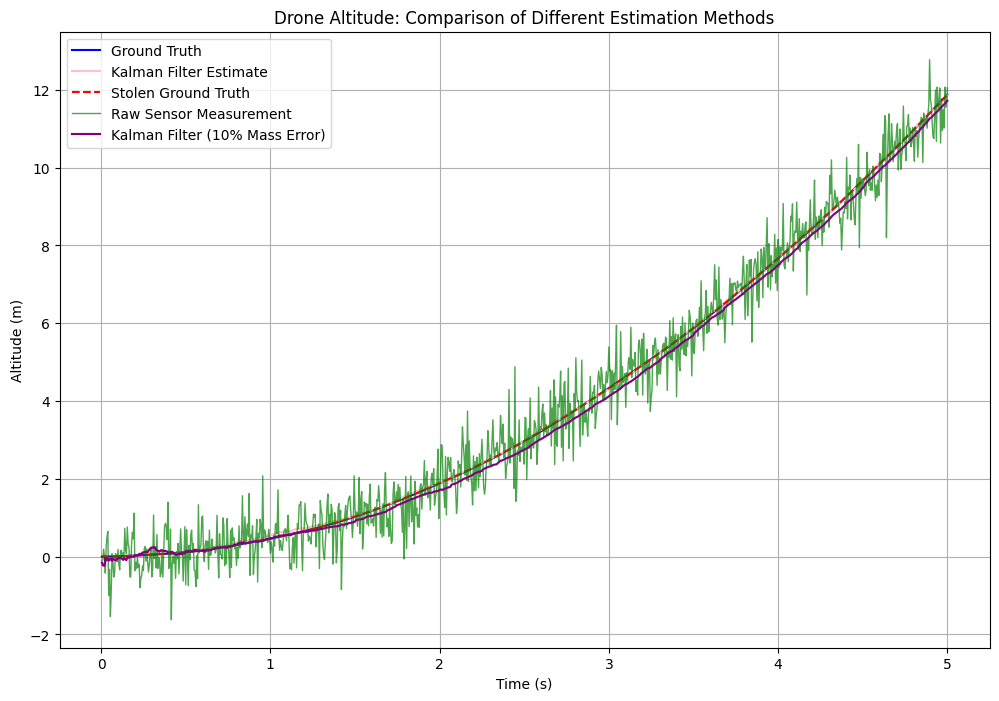

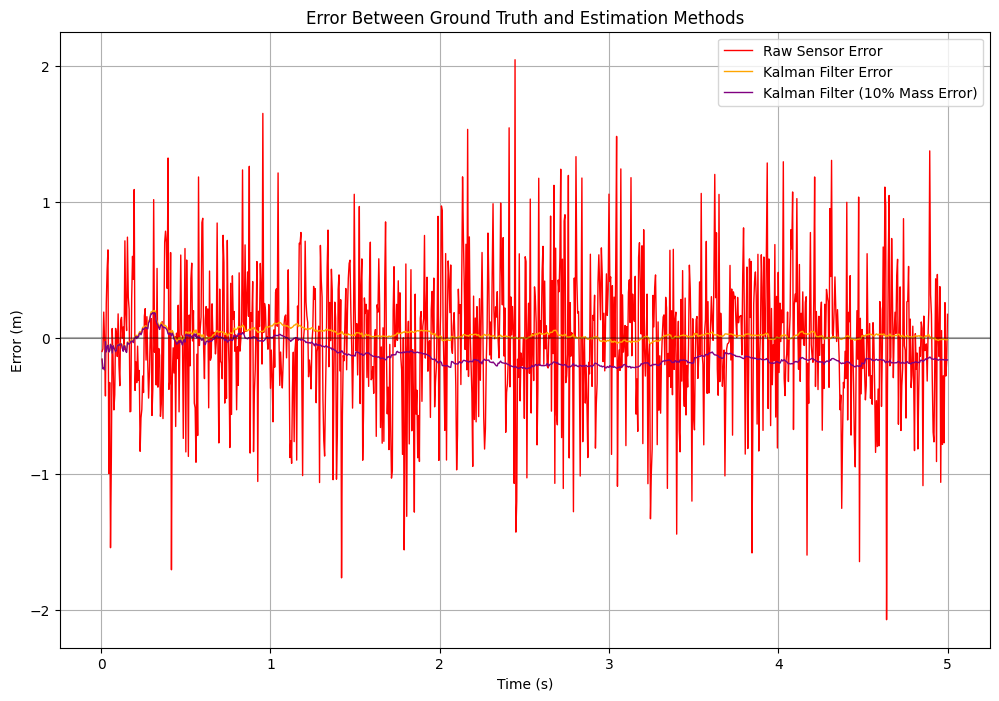

In [3]:
plt.figure(figsize=(12, 8))

# Plot all altitude data
plt.plot(all_t, height_ground_truth, label='Ground Truth', color='blue', linewidth=1.5)
plt.plot(all_t, height_estimate_kf, label='Kalman Filter Estimate', color='pink', linewidth=1.5)
plt.plot(all_t, height_estimate_stolen, label='Stolen Ground Truth', color='red', linewidth=1.5, linestyle='--')
plt.plot(all_t, height_estimate_unfiltered, label='Raw Sensor Measurement', color='green', linewidth=1, alpha=0.7)
plt.plot(all_t, height_estimate_kf_wrong_mass, label='Kalman Filter (10% Mass Error)', color='purple', linewidth=1.5)

plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')  
plt.title('Drone Altitude: Comparison of Different Estimation Methods')
plt.legend()
plt.grid(True)
plt.show()

# Plot the error between ground truth and each estimation method
plt.figure(figsize=(12, 8))
plt.plot(all_t, [est - gt for est, gt in zip(height_estimate_unfiltered, height_ground_truth)], 
         label='Raw Sensor Error', color='red', linewidth=1)
plt.plot(all_t, [est - gt for est, gt in zip(height_estimate_kf, height_ground_truth)], 
         label='Kalman Filter Error', color='orange', linewidth=1)
plt.plot(all_t, [est - gt for est, gt in zip(height_estimate_kf_wrong_mass, height_ground_truth)], 
         label='Kalman Filter (10% Mass Error)', color='purple', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')  
plt.title('Error Between Ground Truth and Estimation Methods')
plt.legend()
plt.grid(True)
plt.show()